# Measuring Single Chip Performance on Tensor Processing Tasks


In [2]:
from high_performance_jax.single_chip_performance import *

[CpuDevice(id=0)]
dim 4 | average time (ms): 0.01 | hbm xfer/s 3636363.6364 | flops 112 | tera flops/s 0.0000
dim 8 | average time (ms): 0.03 | hbm xfer/s 7245283.0189 | flops 960 | tera flops/s 0.0000
dim 16 | average time (ms): 0.06 | hbm xfer/s 13039049.2360 | flops 7,936 | tera flops/s 0.0001
dim 32 | average time (ms): 0.07 | hbm xfer/s 46126126.1261 | flops 64,512 | tera flops/s 0.0010
dim 64 | average time (ms): 0.14 | hbm xfer/s 88402877.6978 | flops 520,192 | tera flops/s 0.0037
dim 128 | average time (ms): 0.42 | hbm xfer/s 116253547.7767 | flops 4,177,920 | tera flops/s 0.0099
dim 256 | average time (ms): 0.88 | hbm xfer/s 223088619.0854 | flops 33,488,896 | tera flops/s 0.0380
dim 512 | average time (ms): 2.06 | hbm xfer/s 380894076.6213 | flops 268,173,312 | tera flops/s 0.1299
dim 1024 | average time (ms): 4.40 | hbm xfer/s 714921933.5924 | flops 2,146,435,072 | tera flops/s 0.4878
dim 2048 | average time (ms): 29.89 | hbm xfer/s 420954254.4009 | flops 17,175,674,880 | te

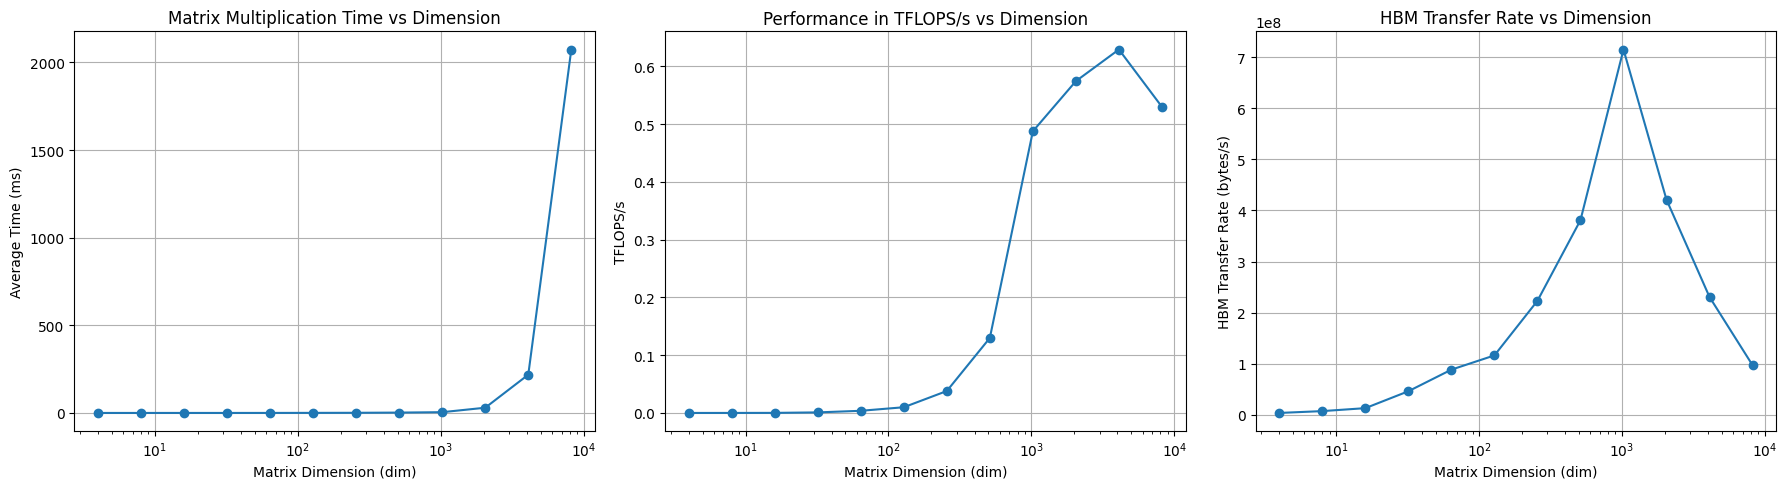

In [4]:
dtype = jnp.uint8
print(jax.devices())
jax.config.update("jax_default_matmul_precision", "BF16_BF16_F32") # Set the default precision for matrix multiplication

dims = [2**i for i in range(2, 14)]
times = []
tflops = []
hbm_rates = []

for dim in dims:
    A = jnp.ones((dim, dim), dtype=dtype)
    B = jnp.ones((dim, dim), dtype=dtype)
    task = "matmul"

    average_time_ms = timeit(jax.jit(matmul), A, B)
    flops = measure_tpu_flops(A, B, task)
    times.append(average_time_ms)
    tflops.append(1000 * flops / average_time_ms / 10**12)
    hbm_xfer = measure_tpu_hbm_memory_transfer(A, B, task, dtype)
    hbm_rates.append(1000 * hbm_xfer / average_time_ms)

    print(f"dim {dim} | average time (ms): {average_time_ms:.2f} | "
            f"hbm xfer/s {hbm_rates[-1]:0.4f} | "
            f"flops {flops:,} | "
            f"tera flops/s {tflops[-1]:0.4f}")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

ax1.plot(dims, times, marker='o')
ax1.set_xscale('log')
ax1.set_xlabel("Matrix Dimension (dim)")
ax1.set_ylabel("Average Time (ms)")
ax1.set_title("Matrix Multiplication Time vs Dimension")
ax1.grid(True)

ax2.plot(dims, tflops, marker='o')
ax2.set_xscale('log')
ax2.set_xlabel("Matrix Dimension (dim)")
ax2.set_ylabel("TFLOPS/s")
ax2.set_title("Performance in TFLOPS/s vs Dimension")
ax2.grid(True)

ax3.plot(dims, hbm_rates, marker='o')
ax3.set_xscale('log')
ax3.set_xlabel("Matrix Dimension (dim)")
ax3.set_ylabel("HBM Transfer Rate (bytes/s)")
ax3.set_title("HBM Transfer Rate vs Dimension")
ax3.grid(True)

plt.tight_layout()
plt.show()

